# Step 4 - Compare the structures

In [1]:
%matplotlib inline

from sys import path as spath
spath.append("scripts/")
from Bio.SeqIO import index as fasta_index, parse
from CRISPRtools import *
from easyFunctions import *
from InfernalResults import *
from os import chdir, path, stat, system
from pandas import DataFrame, read_excel, Series
from pickle import load
from Rho import *

gene = 'Cas9'
chdir("data")
print("Loading Operons")
casOperons = load(open("pickles/%s_Operons.p" % gene,"rb"))
print("Loading tracr search results")
infernalResults = ProcessInfernal(4,gene,False) #Results from search for tracrs in all assemblies
print("There are %s CRISPR-Cas Systems with a tracr Result" % (comma(len(infernalResults.seqTracrs))))

# import dill
# if path.exists("pickles/Step4.db"): 
#     dill.load_session('pickles/Step4.db')
#     print "Loaded Session"

Loading Operons
Loading tracr search results
There are 27,735 CRISPR-Cas Systems with a tracr Result


In [116]:
allAssemblies = load(open("pickles/All_%s_Representative_Assemblies.p" % (gene),'rb'))
allProts = dict(fasta_index("proteins/All_Cas9-Like-filtered.faa",'fasta'))
len(allProts),len(set(allAssemblies).intersection(allProts.keys())),len(allAssemblies)

(26857, 26856, 28855)

In [117]:
len(set(infernalResults.seqTracrs).intersection(allProts)),len(infernalResults.seqTracrs)

(25584, 27735)

In [128]:
allCasAAsFile = "proteins/All_%s-Like.faa" % (gene)
casAAs = dict(fasta_index(allCasAAsFile,'fasta'))
print(len(casOperons.seqMap.protToAsm),len(casAAs))
unUsed = set(casOperons.seqMap.protToAsm).difference(casAAs)
print(len(unUsed))

51219 29225
21994


In [139]:
pres,absnt = 0,0
for protID in unUsed:
    #operon = casOperons.operons[casOperons.seqMap[protID]]
    #absnt+= int(operon.seq is not None)
    #del casOperons.operons[casOperons.seqMap[protID]]
    try:
        operon = casOperons.operons[casOperons.seqMap[protID]]
        pres +=1
        del casOperons.operons[casOperons.seqMap[protID]]
    except:
        absnt+=1
absnt,pres,len(unUsed)
        
    

(21994, 0, 21994)

In [124]:
sm = casOperons.seqMap

In [126]:
len(sm.protToAsm)

51219

# Combining structure hits

In [26]:
def combineResults(seqTracrs):
    seqTracrs = [item for sublist in seqTracrs for item in sublist]
    if len(seqTracrs) == 1: return [seqTracrs]
    seqTracrs.sort(key=lambda x: x.location.start)
    prev = seqTracrs[0]
    locations = [[prev]]
    clusterNum = 0
    for i,tracr in enumerate(seqTracrs[1:]): 
        if tracr.location.overlaps(prev.location): 
#             print("\t",tracr,'\t',prev,"Overlaps")
            locations[clusterNum].append(tracr)
        else:
#             print("\t",tracr,'\t',prev,"New Cluster")
            locations.append([tracr])
            clusterNum += 1
        prev = tracr
#     for i, group in enumerate(locations):
#         print ("Group %i: %i" % (i,len(group)))
#         for loc in group: print("\t",loc)
    return locations

# Finding terminator overlap with structure results

In [33]:
confirmedResults, distr = {}, []
for i,protID in enumerate(infernalResults.seqTracrs):
    if i%250==0:print(i,len(confirmedResults))
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    
    combinedResults = combineResults(list(infernalResults.seqTracrs[protID].values())) #Cluster the structural search results by location
    crispr.terminators.sort(key=lambda x: x.genomeLocation.start) #Sort terminators by their genomic location

    validTracrs = []
    print(protID)
    for group in combinedResults:
        overlapsTerminator = False
        for terminator in crispr.terminators:
            for tracr in group:
                overlapsTerminator = terminator.genomeLocation.overlaps(tracr.location)
                if overlapsTerminator: 
                    print('\t',tracr,'\t',terminator)
                    validTracrs.append([tracr,terminator])
                    break
            if overlapsTerminator: break
    break
    if len(validTracrs)>0: 
        distr.append(len(validTracrs))
        confirmedResults[protID] = validTracrs
# print("There are %i protIDs with confirmed antis" % len(confirmedResults))
# dump(confirmedResults,open("pickles/OverlappingTracrs.p",'wb'))

0 0
AACPSW010000030.1_ORF701
	 Cluster_267 [14923	15163] - 8.6e-22 	 Seq_15030_15406_D	True	[23	63] +	False	
	 Cluster_292 [15262	15359] + 2.5e-06 	 Seq_15030_15406_D	True	[23	63] +	False	


In [113]:
operon.assembly

'/mnt/research/germs/shane/databases/assemblies/NCBI/genbank/bacteria/GCA_005325615.1.fasta'

In [52]:
def pullSeq(seqRec,coord):
    if not coord.strand:  return seqRec.seq[coord.start:coord.end].reverse_complement()
    return seqRec.seq[coord.start:coord.end]


seqs = fasta_index('tmp/possibleTracrs.fasta',"fasta")
for rep in crispr.antiRepeats:
    print(rep,pullSeq(operon.seq,rep))

[15031	15056] - ATAAGAAATTTAAAAAGGGACTAAA
[15125	15162] + TATTTTACCATAAAGAAATTTAAAAAGGGACTAAAAC
[15455	15491] + TATTTTACCATAAAGAAATTTAAAAAGGGACTAAAA


In [103]:
from types import MethodType

def clusterBLASTResults(self, blastResults,protID):
    try:
        self.antiRepeats={}
        spacerLen = len(max(self.spacers, key=len)) + 10
        blastResults.sort()
        prevResult,nextResult = blastResults[0],blastResults[0]
        self.antiRepeats[prevResult] = AntiRepeatCandidate(prevResult,name=protID)
        if len(blastResults) == 1: return #If there is only 1 result stop
        self.repeats = blastResults
        for nextResult in blastResults[1:]:
            if prevResult.distance(nextResult) > spacerLen: 
                self.antiRepeats[nextResult] = AntiRepeatCandidate(nextResult,name=protID)
                if prevResult in self.antiRepeats: self.antiRepeats[prevResult].addDir()
                else: self.antiRepeats[prevResult] = AntiRepeatCandidate(prevResult,'downstream',name=protID)
            prevResult=nextResult
        if nextResult in self.antiRepeats: self.antiRepeats[nextResult].addDir()
        else:  self.antiRepeats[nextResult] = AntiRepeatCandidate(nextResult,'downstream',name=protID)
    except: pass

In [105]:
for protID in ['AACPSW010000030.1_ORF701']:
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    crispr.terminators = []
    crispr.antiRepeats = {}
    crispr.repeatSeqs(protID,open(operon.getRepeatPath(protID),'w'))
    blastResults = parseBLAST(BLAST_short(operon.getRepeatPath(protID), operon.getFastaPointer(protID), "blastout/conRepeats/%s.xml" % (protID)))
    blastResults.sort()
    crispr.clusterBLASTResults = MethodType(clusterBLASTResults,crispr)
    crispr.clusterBLASTResults(blastResults,protID)
    print("antis")
    for cord in crispr.antiRepeats:
        print('\t',cord)
    
    crispr.getAntiRepeatCandidates(open("tmp/possibleTracrs.fasta","w"), operon.getSeq())
    print()
    res = system("~/bin/Arnold/erpin ~/bin/Arnold/rho-indep.epn tmp/possibleTracrs.fasta -1,4 -add 1 4 2 -pcw 3.0 -cutoff 100% >tmp/rhoInd.out")
    erpOut = ErpinOut()
    crispr.getTracrRNA_Candidates(erpOut,open("test.txt",'w'))
    print("Terminators")
    for term in crispr.terminators:
        print('\t',term)

antis
	 [15031	15056] -
	 [15125	15162] +
	 [15455	15491] +

Terminators
	 AACPSW010000030.1_ORF701_15030_15406_D	True	[23	63] +	False	
	 AACPSW010000030.1_ORF701_15454_15841_D	True	[29	79] +	False	


In [108]:
%%bash 
cat tmp/possibleTracrs.fasta

>AACPSW010000030.1_ORF701_14681_15057_U
CGTTTATATGCGTATTTGCAAGGGTTTAAGTTCTGCAAAAAGTTCTATTGAAAATGTAAAAAAGATTTTGCCACCTTATGGAAATGTAAGGGCTTTAATCATCACTGAAAAGCAGTTTGATAAAATGGAGCTTTTGCTTGGTGGCATAGTTTTTAACGAAAAAGTTAATAACGAAACCAATTTAACGCTTTTTGATATAGATAGTCATGGAGAATTTAAATATAAAAATTCAAATAACGAAGAAATTCAAATAAACAAAAAACAAGAAAAATATCATCAGCAAAATTTATTTGAATTTTAAAAGCGGTTTTAGGGGATTGTAACCCCGCAGAGTCCCGCAAACTCTTTATTTTAGTCCCTTTTTAAATTTCTTATG
>AACPSW010000030.1_ORF701_15030_15406_D
TTTTAGTCCCTTTTTAAATTTCTTATGAGATTATAGCATAATTTTTGCTATTTTTCATGAAAAAACCCCGAAATTTTCATTATCTGGTAAATATCTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACATCGTTTTTAGTTTTTTCATAATCTTCATTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACTTCTATATCTCCTACCATTCCGCAACCTGTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACATATCACATAAAGCATCCGCTCTTTCTAAAATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACAATTATTATAAGTAAAATTGAGATTAAAATATTTTACCATAAAGAA
>AACPSW010000030.1_ORF701_14775_15163_U
TTAATCATCACTGAAAAGCAGTTTGATAAAATGGAGCTTTTGCTTGGTGGCATAGTTTTTAACGAAAAAGTTAATAACGAAACCAATTTAACGCTTTTTGATATAGATAGTCATGGAGAATTTAAA

In [111]:
%%bash
cat sequences/conRepeats/AACPSW010000030.1_ORF701.fasta
echo -en "\n\nRho Out Stuff:"
cat tmp/rhoInd.out

>AACPSW010000030.1_ORF701_0
TATTTTACCATAAAGAAATTTAAAAAGGGACTAAAAC


Rho Out Stuff:
Training set:	"/mnt/home/dooleys1/bin/Arnold/rho-indep.epn":
		1201 sequences of length 71
Cutoff:		4.31  

Database:	"tmp/possibleTracrs.fasta"
		1371 nucleotides to be processed in 4 sequences
		ATGC ratios: 0.383  0.341  0.134  0.143
E-value at cutoff 4.3 for 1.4Kb double strand data: 1.98e+00

>AACPSW010000030.1_ORF701_14681_15057_U
FW   1      81..144      6.71  5.84e-01
GAAATGTAAGG.GCTTTAAT.catcactgaaaagcagtttgataa------.AATGGAGC.-.TTTTGCTTGGTGG
FW   2     303..373      7.88  3.08e-01
AGCGGTTTTAG.GGGATTGT.aaccccgcagagtcccgcaaactctttatt.TTAGTCCC.t.TTTTAAATTTCTT
>AACPSW010000030.1_ORF701_15030_15406_D
FW   1      23..63       5.56  1.07e+00
TTATGAGATTA.TAGCATAA.t-----------------------------.TTTTGCTA.-.TTTTTCATGAAAA
FW   2     114..157      6.40  6.91e-01
TTTAAAAAGGG.ACTAAAAC.atcg--------------------------.TTTTTAGT.-.TTTTTCATAATCT
>AACPSW010000030.1_ORF701_14775_15163_U
FW   1     209..279      7.88 

In [ ]:
 
            GTTTTAGTCCCTTTTTAAATTTCTTTATGGTAAAATA
CGCAAACTCTTTATTTTAGTCCCTTTTTAAATTTCTTATG

In [112]:
RC('TATTTTACCATAAAGAAATTTAAAAAGGGACTAAAAC')

'GTTTTAGTCCCTTTTTAAATTTCTTTATGGTAAAATA'

In [102]:
%%bash
cat tmp/possibleTracrs.fasta

>AACPSW010000030.1_ORF701_14681_15057_U
CGTTTATATGCGTATTTGCAAGGGTTTAAGTTCTGCAAAAAGTTCTATTGAAAATGTAAAAAAGATTTTGCCACCTTATGGAAATGTAAGGGCTTTAATCATCACTGAAAAGCAGTTTGATAAAATGGAGCTTTTGCTTGGTGGCATAGTTTTTAACGAAAAAGTTAATAACGAAACCAATTTAACGCTTTTTGATATAGATAGTCATGGAGAATTTAAATATAAAAATTCAAATAACGAAGAAATTCAAATAAACAAAAAACAAGAAAAATATCATCAGCAAAATTTATTTGAATTTTAAAAGCGGTTTTAGGGGATTGTAACCCCGCAGAGTCCCGCAAACTCTTTATTTTAGTCCCTTTTTAAATTTCTTATG
>AACPSW010000030.1_ORF701_15030_15406_D
TTTTAGTCCCTTTTTAAATTTCTTATGAGATTATAGCATAATTTTTGCTATTTTTCATGAAAAAACCCCGAAATTTTCATTATCTGGTAAATATCTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACATCGTTTTTAGTTTTTTCATAATCTTCATTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACTTCTATATCTCCTACCATTCCGCAACCTGTATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACATATCACATAAAGCATCCGCTCTTTCTAAAATTTTACCATAAAGAAATTTAAAAAGGGACTAAAACAATTATTATAAGTAAAATTGAGATTAAAATATTTTACCATAAAGAA
>AACPSW010000030.1_ORF701_14775_15163_U
TTAATCATCACTGAAAAGCAGTTTGATAAAATGGAGCTTTTGCTTGGTGGCATAGTTTTTAACGAAAAAGTTAATAACGAAACCAATTTAACGCTTTTTGATATAGATAGTCATGGAGAATTTAAA

In [8]:
for res in confirmedResults:
    print(res)
    for val in confirmedResults[res]:
        for clus in val:
            print('\t',clus)
    break

AACPSW010000030.1_ORF701
	 Cluster_267 [14923	15163] - 8.6e-22
	 Seq_15030_15406_D	True	[23	63] +	False	
	 Cluster_292 [15126	15251] + 7.4e-08
	 Seq_15030_15406_D	True	[23	63] +	False	


In [4]:
cluster_data = read_excel("tables/tracrRNA_SearchResults.xlsx")
cluster_data.set_index("Cluster Name",inplace=True)
cluster_data.head()

,Num w/Tracr,Seqs,% Tracrs Found,Top TRACR,Top Count,Top Percent,2nd TRACR,2nd Count,3rd TRACR,3rd Count,Total %,Total Uniq,Top Tracr Rep,2nd Tracr Rep,3rd Tracr Rep
Cluster Name,,,,,,,,,,,,,,,
Cluster 0,13539,13641,0.992523,Cluster_25,13539,1.000000,NaN,0,NaN,0,1.0,1,AABIVK010000025.1_ORF1062,NaN,NaN
Cluster 1,2872,2873,0.999652,Cluster_155,2141,0.745474,Cluster_79,731,NaN,0,1.0,2,RELL01000004.1_ORF1065,AAAZIK010000007.1_ORF9378,NaN
Cluster 2,1063,1063,1.000000,Cluster_155,625,0.587959,Cluster_79,437,Cluster_28,1,1.0,3,CP028183.1_ORF175249,AAAUHC010000003.1_ORF11760,NZ_QRRD01000004.1_ORF13432
Cluster 3,842,842,1.000000,Cluster_155,837,0.994062,Cluster_79,5,NaN,0,1.0,2,NZ_UHFG01000004.1_ORF60728,LRHC01000005_ORF1736,NaN
Cluster 4,762,765,0.996078,Cluster_155,757,0.993438,Cluster_79,5,NaN,0,1.0,2,AUVT01000016_ORF18144,LBKH01000087_ORF733,NaN


In [9]:
fh = open('proteins/%s_RepresentativeProteinss.faa' %gene,'w')
casProts = fasta_index("proteins/All_Cas9-Like.faa","fasta")
for cluster,row in cluster_data.iterrows():
    numWTracr = row.loc['Num w/Tracr']
    if numWTracr == 0:continue
    rec = casProts[row.loc['Top Tracr Rep']]
    rec.description = ""
    write(rec,fh,"fasta")
fh.close()    

In [ ]:
%%bash
sbatch ../scripts/hpc/Alignment.sb

In [11]:
cluster_data = cluster_data[cluster_data['Num w/Tracr']>0]
cluster_data.describe()

,Num w/Tracr,Seqs,% Tracrs Found,Top Count,Top Percent,2nd Count,3rd Count,Total %,Total Uniq
count,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000
mean,16.667101,16.985016,0.961455,15.328339,0.937947,1.244300,0.068404,0.999672,1.224756
std,355.882429,358.525103,0.140277,351.734253,0.147352,21.852614,0.568523,0.004497,0.606064
min,1.000000,1.000000,0.100000,1.000000,0.333333,0.000000,0.000000,0.887500,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,13539.000000,13641.000000,1.000000,13539.000000,1.000000,731.000000,10.000000,1.000000,9.000000


In [34]:
from pandas import isnull
only1 = cluster_data[cluster_data['Num w/Tracr']==1]
greaterThan2=cluster_data[cluster_data['Num w/Tracr']>2]
tracrCounts = cluster_data.groupby('Top TRACR')['Top TRACR'].count()

lessThan3 = tracrCounts[tracrCounts<3]
greaterThan3 = tracrCounts[tracrCounts>=3]

counter,op = 0,0
for cluster, row in cluster_data.iterrows():
    if row.loc['Top TRACR'] not in lessThan3: continue #The seq
    for tracr in ["2nd TRACR","3rd TRACR"]:
        counter += int(row.loc[tracr] in greaterThan3)
        
counter

14

In [21]:
fh = open('proteins/Cas9sWithTracrHit.faa','w')
allProts = fasta_index('proteins/All_Cas9-Like.faa','fasta')
for protID in infernalResults.seqTracrs:
    write(allProts[protID],fh,'fasta')
fh.close()

In [ ]:
%%bash
cd proteins
cd-hit -i Cas9sWithTracrHit.faa -M 0 -d 0 -c .90 -sc 1 -o Cas9sWithTracrHit.grouped.faa

In [19]:
reps = fasta_index("proteins/Cas9sWithTracrHit.grouped.faa")

In [23]:
for cluster in infernalResults.seqTracrs["DHEB01000171_ORF121"]:
    print(cluster, infernalResults.seqTracrs["DHEB01000171_ORF121"][cluster])

Cluster_144 Cluster_144 [6618	6698] + 5e-05
Cluster_188 Cluster_188 [6614	6696] + 2.5e-05
Cluster_436 Cluster_436 [6616	6700] + 7.6e-08


In [25]:
protID = "NZ_ACLQ01000019_ORF8279"
for cluster in infernalResults.seqTracrs[protID]:
    print(cluster, infernalResults.seqTracrs[protID][cluster])

Cluster_243 Cluster_243 [134076	134168] - 3.9e-07
Cluster_238 Cluster_238 [134073	134167] - 3.7e-08
Cluster_144 Cluster_144 [134080	134165] - 0.0073
Cluster_382 Cluster_382 [134076	134168] - 5.3e-05
Cluster_120 Cluster_120 [134076	134167] + 2.9e-08
Cluster_169 Cluster_169 [308162	308373] + 7.2e-08
Cluster_322 Cluster_322 [138932	139151] - 3.4e-26
Cluster_436 Cluster_436 [134081	134167] - 0.0022
Cluster_387 Cluster_387 [134071	134164] - 4.6e-12
Cluster_155 Cluster_155 [194533	194669] + 0.0026


Dumping /mnt/research/germs/shane/transActRNA/data/pickles/Cas9_InfernalResults04.p
	Number of results: 27735


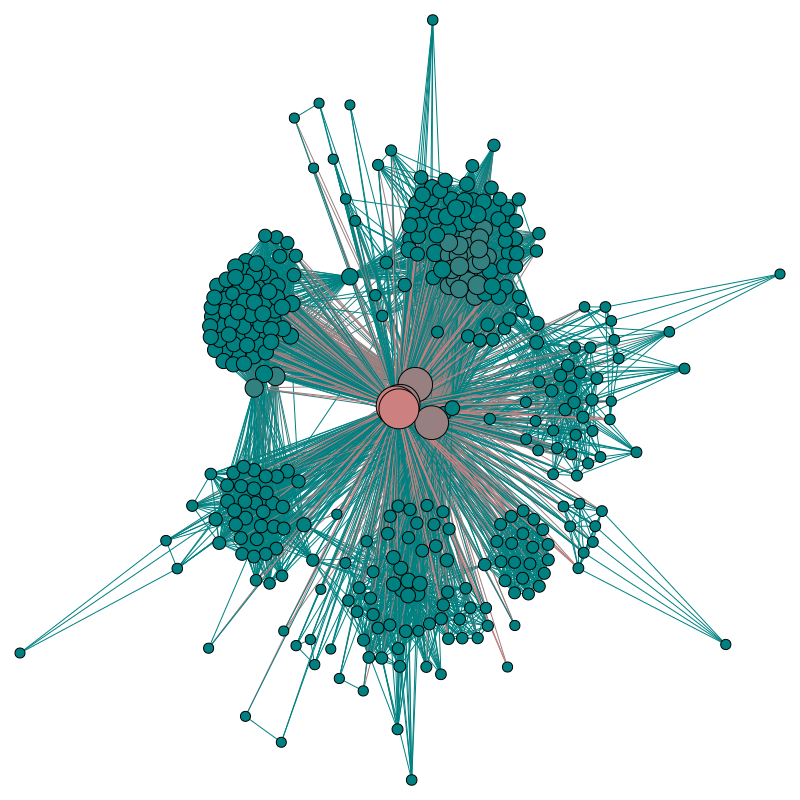

In [2]:
def scale(x, out_range=(1, 10)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

from igraph import Graph,plot
import numpy as np
infernalResults = ProcessInfernal(4,gene) #Results from search for tracrs in all assemblies

clusterGraph = Graph()
allClusters = list(infernalResults.structMapping.keys())
clusterGraph.add_vertices(allClusters)

edges = []
weights = []
for i, cluster1 in enumerate(allClusters):
    for cluster2 in allClusters[i+1:]:
        degrees = len(infernalResults.structMapping[cluster1].intersection(infernalResults.structMapping[cluster2]))
        if degrees>3:
            edges.append((cluster1,cluster2))
            weights.append(degrees)
clusterGraph.add_edges(edges)

to_delete_ids = [v.index for v in clusterGraph.vs if v.degree() < 3]
clusterGraph.delete_vertices(to_delete_ids)

# clusterGraph.es['weight'] = weights
visual_style = {}

# Scale by degree
outdegree = clusterGraph.outdegree()
visual_style["vertex_size"] = scale(outdegree,(10,40))
visual_style["bbox"] = (800,800)
# visual_style["margin"] = 100

# Order vertices in bins based on outdegree
colours = [(0.0, 0.5, 0.5), (0.2, 0.5, 0.5), (0.4, 0.5, 0.5), (0.6, 0.5, 0.5), (0.8, 0.5, 0.5)]
bins = np.linspace(0, max(outdegree), len(colours))  
digitized_degrees =  np.digitize(outdegree, bins)

# Set colors according to bins
clusterGraph.vs["color"] = [colours[x-1] for x in digitized_degrees]

# Also color the edges
for ind, color in enumerate(clusterGraph.vs["color"]):
        edges = clusterGraph.es.select(_source=ind)
        edges["color"] = [color]
        
visual_style["edge_curved"] = False
#visual_style['layout']='kk'
plot(clusterGraph,**visual_style)

In [60]:
degrees = Series(outdegree)
degrees.describe()

count    356.000000
mean      47.235955
std       41.824791
min        3.000000
25%       24.000000
50%       39.500000
75%       65.250000
max      345.000000
dtype: float64

In [54]:
for i in range(100,-1,-5):
    selection = clusterGraph.vs.select(_degree_gt=i)
    highVal = []
    for vert in list(selection): highVal.append(vert['name'])
#     print(i,len(highVal))
# plot(selection.graph,**visual_style)

In [14]:
fh = open("tables/TracrOverLap.tsv",'w')
fh.write('\t'.join(["Cluster1","Cluster2",'OverlapIDs','GenomicOverlap'])+'\n')
for i, cluster1 in enumerate(highVal):
    for cluster2 in highVal[i+1:]:
        overlapIDs = infernalResults.structMapping[cluster1].intersection(infernalResults.structMapping[cluster2])
        genomicOverlap = 0
        for protID in overlapIDs:
            found = False
            for t1 in infernalResults.seqTracrs[protID][cluster1]:
                for t2 in infernalResults.seqTracrs[protID][cluster2]:
                    found = t1.location.overlaps(t2.location)
                    if found: break
                if found: break
            genomicOverlap += int(found)
        if len(overlapIDs) == 0: continue
        percOverlap = genomicOverlap/float(len(overlapIDs))*100.0
        if percOverlap > 75.0:
            fh.write("%s\t%s\t%i\t%i\n" % (cluster1,cluster2,len(overlapIDs),genomicOverlap))
            print(i,cluster1,cluster2,len(overlapIDs),genomicOverlap,percOverlap)
fh.close()


0 Cluster_160 Cluster_118 2 2 100.0
0 Cluster_160 Cluster_292 14651 14626 99.82936318340046
0 Cluster_160 Cluster_11 14463 14463 100.0
0 Cluster_160 Cluster_25 14691 14691 100.0
0 Cluster_160 Cluster_27 14686 14686 100.0
0 Cluster_160 Cluster_84 114 106 92.98245614035088
0 Cluster_160 Cluster_17 2 2 100.0
0 Cluster_160 Cluster_57 14690 14690 100.0
0 Cluster_160 Cluster_116 14485 14485 100.0
0 Cluster_160 Cluster_33 14690 14690 100.0
0 Cluster_160 Cluster_102 14562 14562 100.0
0 Cluster_160 Cluster_408 2 2 100.0
0 Cluster_160 Cluster_354 2 2 100.0
0 Cluster_160 Cluster_88 14690 14690 100.0
0 Cluster_160 Cluster_90 14690 14689 99.9931926480599
0 Cluster_160 Cluster_194 14687 14687 100.0
0 Cluster_160 Cluster_38 14690 14690 100.0
0 Cluster_160 Cluster_405 14686 14686 100.0
0 Cluster_160 Cluster_403 14683 14682 99.99318940271061
0 Cluster_160 Cluster_267 14689 14689 100.0
0 Cluster_160 Cluster_68 40 40 100.0
0 Cluster_160 Cluster_446 14686 14686 100.0
0 Cluster_160 Cluster_24 14685 14685 1

In [32]:
protID = 'UTAE01000009.1_ORF6083'
print(infernalResults.seqTracrs[protID]['Cluster_222'])

Cluster_222 [319505	319629] - 5.3e-05


In [ ]:
equivalencies = {"Cluster_170":"Cluster_339",'Cluster_222':'Cluster_79','Cluster_60':'Cluster_9',"Cluster_25":"Cluster_38"}

In [44]:
from pandas import read_csv
relations = read_csv("tables/TracrOverLap.tsv",sep='\t')
relations["Perc"] = relations['GenomicOverlap']/relations['OverlapIDs']
relations.sort_values(['Perc','GenomicOverlap'],ascending=False,inplace=True)
relations = relations[relations.Perc == 1.0]
relations["GenomicOverlap"].plot.hist()

In [52]:
clusterClasses = Equivalency()
relations = relations[relations["GenomicOverlap"]>10000]
for i,row in relations.iterrows():
    clusterClasses[row.loc["Cluster1"]] = row.loc["Cluster2"]
print(clusterClasses.clade.keys())

dict_keys(['Cluster_60', 'Cluster_25', 'Cluster_267', 'Cluster_171'])


In [66]:
def getOverlappingIDs(cluster1,cluster2):
    return infernalResults.structMapping[cluster1].intersection(infernalResults.structMapping[cluster2])

def tracrsOverlap(protID,cluster1,cluster2):
    for t1 in infernalResults.seqTracrs[protID][cluster1]:
        for t2 in infernalResults.seqTracrs[protID][cluster2]:
            if t1.location.overlaps(t2.location): return True,t1,t2
    return False,None,None

In [72]:
relationIDS = {}
allClades = {}
noOverlap = 0
for clade,eqClades in clusterClasses.clade.items():
    allClades[clade]={}
    #for protID in infernalResults.structMapping[clade]: relationIDS[protID] = clade
    for eqClade in eqClades:
        overlap = getOverlappingIDs(clade,eqClade)
        for protID in overlap: 
            found,tracr1,tracr2 = tracrsOverlap(protID,clade,eqClade)
            if found and protID in relationIDS:
                x1,x2 = relationIDS[protID]
                val = not (tracr1.location.overlaps(x1.location) and
                tracr1.location.overlaps(x2.location) and
                tracr2.location.overlaps(x1.location) and
                tracr2.location.overlaps(x2.location))
                if val:
                    print(protID)
                    print(x1)
                    print(tracr1)
                    print(x2)
                    print(tracr2)
                    die
                noOverlap += int(val)
            if found:
                relationIDS[protID] = (tracr1,tracr2)
                allClades[clade][protID] = tracr2
    print(clade,len(relationIDS),noOverlap)

NZ_CM000776_ORF101570
Cluster_60 [1561492	1561816] - 5.9e-30
Cluster_60 [1556532	1556877] + 6.1e-39
Cluster_82 [1561426	1561625] + 0.0045
Cluster_97 [1556516	1556877] + 5e-21


NameError: name 'die' is not defined

In [ ]:
for protID in infernalResults.seqTracrs:
    

In [50]:
class Equivalency:
    def __init__(self):
        self.ids = set()
        self.clade = {}
        self.revMap = {}
    def __setitem__(self,k,v):
        if k in self.clade: self.clade[k].add(v)                  #K is a key
        elif k in self.ids: k = self.revMap[k]                    #K has been used
        elif v in self.ids: self[v]=k; return                             #V already exists
        else: self.clade[k] = set()                        #New K new V
        self.revMap[v] = k    
        self.clade[k].add(v)
        self.ids.add(v)
        self.ids.add(k)
                 

In [ ]:
equivalents = Equivalency()

In [13]:
# chdir('conseqs4')
from os import listdir,system
dirs = listdir("./")
for dirName in dirs:
    chdir(dirName)
    for fname in listdir("./"):
        if "Seq" in fname: system("mv %s %s_%s"%(fname,dirName,fname))
    chdir('../')


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
newcolors = viridis(np.linspace(0, 1, 12))
newcmp = ListedColormap(newcolors)

print(newcmp)

In [6]:
# import colorsys

# def get_N_HexCol(N=5):
#     HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
#     print(HSV_tuples)
#     hex_out = []
#     for rgb in HSV_tuples:
#         rgb = map(lambda x: int(x*255),colorsys.hsv_to_rgb(*rgb))
#         hex_out.append("".join(map(lambda x: chr(x).encode('hex'),rgb)))
#     return hex_out
# print(get_N_HexCol())

# count = 0
# for protID,ids in infernalResults.seqTracrs.items():
#     print(protID)
#     print(len(ids))
#     count += 1
#     if count == 10: break

# seqTracrCounter.(len(infernalResults.seqTracrs))
# from pandas import Series
# seqTracrCounter = Series(seqTracrCounter)
# seqTracrCounter[seqTracrCounter<10]

seqTracrCounter = Counter({protID:len(ids) for protID,ids in infernalResults.seqTracrs.items()})
seqTracrCounter

In [2]:
allCasAssemblies = load(open("pickles/All_%s_Representative_Assemblies.p" % gene,"rb"))
infernalResults = ProcessInfernal(4,gene) #Results from search for tracrs in all assemblies
cas9Clusters = processClusterFile("clusters/%s-Like-clustered.faa.clstr" % (gene))
clusterCounter = Counter({clustID:len(ids) for clustID,ids in infernalResults.structMapping.items()})
idsWithTracrStructure = set(allCasAssemblies).intersection(infernalResults.seqTracrs.keys())
missingIDs = set(allCasAssemblies).difference(infernalResults.seqTracrs.keys())
seqTracrs = infernalResults.seqTracrs
biggestClusters = {protID:findBiggestCluster(seqTracrs[protID].keys(),clusterCounter) for protID in idsWithTracrStructure}

Dumping /mnt/research/germs/shane/transActRNA/data/pickles/Cas9_InfernalResults04.p
	Number of results: 27735


In [13]:
def selectLongestCRISPR(tracrID,ids,infernalResults):
    maxRepeats = 0
    maxID = ''
    for protID in ids:
        if protID not in infernalResults.structMapping[tracrID]:continue
        operon = casOperons.operons[casOperons.seqMap[protID]]
        crispr = operon.getCRISPR(protID)
        if len(crispr.repeatCoords) > maxRepeats:
            maxRepeats = len(crispr.repeatCoords)
            maxID = protID
    return maxID    

In [8]:
fh = open("Cas9SystemDetails.txt","w")
fh.write("\t".join(["ClusterID","ProtID","CRISPR Type","Repeats","Num ConSeqs","Consensus Seqs"]))
for cluster, seqIDs in cas9Clusters.items():
    for protID in seqIDs:
        operon = casOperons.operons[casOperons.seqMap[protID]]
        crispr = operon.getCRISPR(protID)
        if len(crispr.terminators)>0: 
            print(protID)
            break
    break
fh.close()

In [23]:
fh = open("tracrRNA_SearchResults.txt","w")
fh.write("\t".join(["Cluster Name","Sequences","Num w/Tracr","Top TRACR","Top Count","2nd TRACR","2nd Count","3rd TRACR","3rd Count","Total Uniq",
                    'Top Tracr Rep','2nd Tracr Rep','3rd Tracr Rep'])+"\n")
row = "%s\t%i\t%i\t%s\t%i\t%s\t%i\t%s\t%i\t%i\t%s\t%s\t%s\n"
topStructuresByCluster = {}
zeroCount = 0;count = 0
for cluster, seqIDs in cas9Clusters.items():
    overlap = set(biggestClusters).intersection(seqIDs.members.keys())
    clusterTracrs = Counter()
    clusterMapper = {}
    
    for protID in overlap: 
        topClust = biggestClusters[protID]
        clusterTracrs[topClust]+=1
        try:clusterMapper[topClust].add(protID)
        except:clusterMapper[topClust]=set([protID])
        
    topTracr,topCount,secondTracr,secondCount,thirdTracr,thirdCount,numOfTracrs = '',0,'',0,'',0,len(clusterTracrs)
    ClusterRep1,ClusterRep2,ClusterRep3 = '','',''
    mostCommon = clusterTracrs.most_common(3)

    try: 
        topTracr,    topCount           = mostCommon[0]
        ClusterRep1 = selectLongestCRISPR(topTracr,clusterMapper[topTracr],infernalResults)
        topStructuresByCluster[cluster] = {0:topTracr}
        secondTracr, secondCount        = mostCommon[1]
        ClusterRep2 = selectLongestCRISPR(secondTracr,clusterMapper[secondTracr],infernalResults)
        topStructuresByCluster[cluster][1] = secondTracr
        thirdTracr,  thirdCount         = mostCommon[2]
        ClusterRep3 = selectLongestCRISPR(thirdTracr,clusterMapper[thirdTracr],infernalResults)
        topStructuresByCluster[cluster][2] = thirdTracr
    except:pass
    
    if numOfTracrs != 0: count+=1
    else: zeroCount +=1
    fh.write(row % (cluster,len(seqIDs),len(overlap),topTracr,topCount,secondTracr,secondCount,thirdTracr,thirdCount,numOfTracrs,ClusterRep1,ClusterRep2,ClusterRep3))
fh.close()
zeroCount,count

(612, 1535)

In [4]:
def countOnes(tracrCounter):
    retSet = set()
    for cluster, count in tracrCounter.items():
        if count == 1: retSet.add(cluster)
    return retSet

In [5]:
#Pick a representative
cas9Proteins = fasta_index("proteins/All_Cas9-Like-filtered.faa","fasta")
#idsWithTracrStructure
len(cas9Proteins),len(cas9Clusters.revMap)

tracrCounter = Counter()
for cluster in topStructuresByCluster: tracrCounter[topStructuresByCluster[cluster][0]]+=1
print("%i structures using top" %(len(tracrCounter)))

oneCounterSet = countOnes(tracrCounter) 
tracrCounter = Counter()
for cluster in topStructuresByCluster: 
    structure = topStructuresByCluster[cluster][0]
    if structure in oneCounterSet and 1 in topStructuresByCluster[cluster]:
        tracrCounter[topStructuresByCluster[cluster][1]]+=1
    else:tracrCounter[topStructuresByCluster[cluster][0]]+=1
print("%i structures using optional 2" %(len(tracrCounter)))

twoCounterSet = countOnes(tracrCounter) 
tracrCounter = Counter()
for cluster in topStructuresByCluster: 
    structure = topStructuresByCluster[cluster][0]
    if structure in twoCounterSet and 2 in topStructuresByCluster[cluster]:
        tracrCounter[topStructuresByCluster[cluster][2]]+=1
    elif structure in oneCounterSet and 1 in topStructuresByCluster[cluster]:
        tracrCounter[topStructuresByCluster[cluster][1]]+=1
    else:tracrCounter[topStructuresByCluster[cluster][0]]+=1
print("%i structures using optional 2" %(len(tracrCounter)))
    
#     seqIDs = cas9Clusters[cluster]
#     print(cluster,len(seqIDs))
    #What are the structures available for those members?
#     uniqTracrs = set()
#     for protID in overlap: clusterTracrs.add(biggestClusters[protID])   
    #Pick the top 1
#     if len(clusterTracrs) == 0: continue
#     break

0 structures using top
0 structures using optional 2
0 structures using optional 2


In [2]:
tRound = 0
infernalResults = ProcessInfernal(tRound,gene) # Results from the last structural search



Dumping /mnt/research/germs/shane/transActRNA/data/pickles/Cas9_InfernalResults00.p
	Number of results: 1843


In [26]:
def updateInfernalResults(infernalResults,seqMap):
    clusterCounter = Counter()
    for clusterID,ids in infernalResults.structMapping.items():
        intersection = seqMap.intersection(ids)
        for protID in intersection: ids.remove(protID)
        if len(ids) == 0: continue
        clusterCounter[clusterID] = len(ids)
    return clusterCounter

In [7]:
from pandas import DataFrame
res=infernalResults
clusters = list(res.structMapping.keys())
seqs = list(res.seqTracrs.keys())
data = {}
for seqID in seqs:
    for clus in clusters:
        try: data[seqID][clus] = int(clus in res.seqTracrs[seqID])
        except: data[seqID] = {clus:int(clus in res.seqTracrs[seqID])}
data = DataFrame(data)
data = data.T
data.head()

,Cluster_0,Cluster_1,Cluster_10,Cluster_100,Cluster_102,Cluster_103,Cluster_104,Cluster_106,Cluster_107,Cluster_109,...,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99
UQCN01000004.1_ORF1151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MSGX01000058_ORF11706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DBKB01000025.1_ORF350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
URKL01000012.1_ORF87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOSF01000003_ORF727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data.to_csv("tables/Round0_Structures.csv")

The number of repeats in cas related assemblies
count    1843.000000
mean       22.593055
std        26.255352
min         3.000000
25%         8.000000
50%        15.000000
75%        28.000000
max       311.000000
dtype: float64


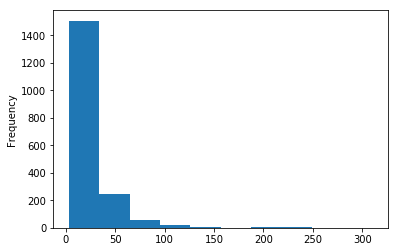

In [3]:
print("The number of repeats in cas related assemblies")
from pandas import Series
dist = []
for i,protID in enumerate(infernalResults.seqTracrs):
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
#     print(dir(crispr))
    dist.append(len(crispr.repeatCoords))
#     break
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

Lengths of consensus repeats
count    2726.000000
mean       38.376742
std         6.785848
min        16.000000
25%        36.000000
50%        36.000000
75%        46.000000
max        62.000000
dtype: float64


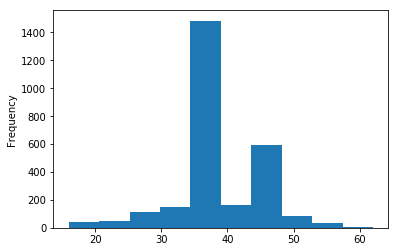

In [4]:
print("Lengths of consensus repeats")
from pandas import Series
dist = []
for i,protID in enumerate(infernalResults.seqTracrs):
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    for repeat in crispr.consensusRepeats: dist.append(len(repeat))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

/mnt/home/dooleys1/bin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


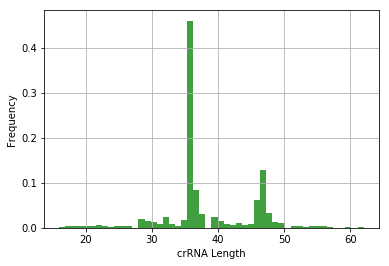

In [5]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(dist, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('crRNA Length')
plt.ylabel('Frequency')
# plt.title("")
# plt.axis([10, 65, 0, 0.20])
plt.grid(True)
# plt.figure()
# plt.show()
plt.savefig('images/crRNA_Length.png')

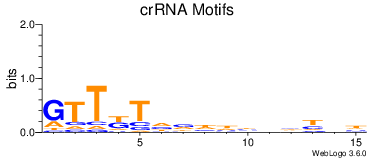

In [7]:
from IPython.display import display, Image
from Bio import motifs as Motifs
dist = []
for i,protID in enumerate(infernalResults.seqTracrs):
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    for repeat in crispr.consensusRepeats: dist.append(repeat[:15])
motif = Motifs.create(dist)
motif.weblogo("images/crRNAStart.png",format='png',**{'logo_title':"crRNA Motifs",'show_ends':False,'unit_name':"",'stack_width':'large','show_errorbars':False})    
display(Image("images/crRNAStart.png"))

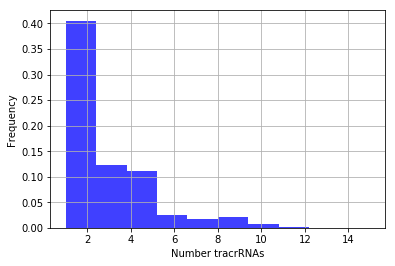

In [11]:
dist = []
for i,protID in enumerate(infernalResults.seqTracrs):
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    
    #Cluster the structural search results by location
    combinedResults = combineResults(list(infernalResults.seqTracrs[protID].values()))
    dist.append(len(combinedResults))
import matplotlib.pyplot as plt
dist = Series(dist)
n, bins, patches = plt.hist(dist, density=1, facecolor='blue', alpha=0.75)
plt.xlabel('Number tracrRNAs')
plt.ylabel('Frequency')
# plt.title("")
# plt.axis([10, 65, 0, 0.20])
plt.grid(True)
# plt.figure()
# plt.show()
plt.savefig('images/numberOfTracrRNAs.png')

In [3]:
distr = []
confirmedResults = {}
for i,protID in enumerate(infernalResults.seqTracrs):
    operon = casOperons.operons[casOperons.seqMap[protID]]
    crispr = operon.getCRISPR(protID)
    
    #Cluster the structural search results by location
    combinedResults = combineResults(list(infernalResults.seqTracrs[protID].values()))
    #Sort terminators by their genomic location
    crispr.terminators = list(crispr.terminators)
    crispr.terminators.sort(key=lambda x: x.genomeLocation.start)
    
#     print("\tTerminator")
    validTracrs = []
    for group in combinedResults:
        overlapsTerminator = False
        for terminator in crispr.terminators:
            overlapsTerminator = terminator.genomeLocation.overlaps(group[0].location)
            if overlapsTerminator: validTracrs.append([group[0],terminator])
#             print("\t\t",terminator,overlapsTerminator)
    #Printing out the results
#     print("\tPossible Tracrs:",len(combinedResults))
#     for tracr in infernalResults.seqTracrs[protID].values(): print("\t\t",tracr)
    
    if len(validTracrs)>0: 
        distr.append(len(validTracrs))
        confirmedResults[protID] = validTracrs
print("There are %i protIDs with confirmed antis" % len(confirmedResults))

There are 1233 protIDs with confirmed antis


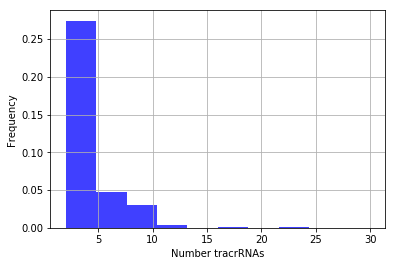

In [10]:
import matplotlib.pyplot as plt
dist = Series(dist)
n, bins, patches = plt.hist(distr, density=1, facecolor='blue', alpha=0.75)
plt.xlabel('Number tracrRNAs')
plt.ylabel('Frequency')
# plt.title("")
# plt.axis([10, 65, 0, 0.20])
plt.grid(True)
# plt.figure()
# plt.show()
plt.savefig('images/numberOfTracrRNAs.png')

In [4]:
from collections import Counter
structCounter = {}
results = {}
for protID, recs in confirmedResults.items():
    for structResult, terminator in recs:
        try: 
            structCounter[structResult.structName] += 1
            results[structResult.structName].append([terminator,protID])
        except: 
            structCounter[structResult.structName] = 1
            results[structResult.structName] = [[terminator,protID]]
structCounter = Counter(structCounter)
structCounter.most_common(5)

[('Cluster_374', 176),
 ('Cluster_434', 92),
 ('Cluster_343', 90),
 ('Cluster_1', 82),
 ('Cluster_47', 79)]

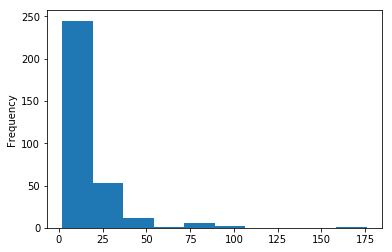

In [6]:
dist = Series(structCounter)
dist.plot.hist();

In [13]:
protIDs = {}
for term, protID in results['Cluster_374']: 
    if protID not in protIDs: protIDs[protID]=term; continue
#     if not path.exists("annotations/blastout/%s.blastout" % (protID)): continue
    print (protID,term,protIDs[protID])
        
    
len(protIDs),len(results['Cluster_374'])        

NZ_LBMG01000069.1_ORF536 Seq_7023_7396_U	False	[286	329] +	True	 Seq_7023_7396_U	False	[286	329] +	True	
NZ_LBMG01000069.1_ORF536 Seq_7372_7745_D	True	[34	79] +	False	 Seq_7023_7396_U	False	[286	329] +	True	
NZ_LBMG01000069.1_ORF536 Seq_7372_7745_D	True	[34	79] +	False	 Seq_7023_7396_U	False	[286	329] +	True	
DIAJ01000017.1_ORF183 Seq_6824_7195_D	True	[40	84] +	False	 Seq_6824_7195_D	True	[40	84] +	False	
SDLV01000053.1_ORF4166 Seq_63382_63750_D	True	[59	109] -	False	 Seq_63382_63750_D	True	[59	109] -	False	
SDLV01000053.1_ORF4166 Seq_63435_63808_U	False	[4	54] +	True	 Seq_63382_63750_D	True	[59	109] -	False	
SDLV01000053.1_ORF4166 Seq_63435_63808_U	False	[4	54] +	True	 Seq_63382_63750_D	True	[59	109] -	False	
SDLV01000053.1_ORF4166 Seq_63784_64157_D	True	[30	98] +	False	 Seq_63382_63750_D	True	[59	109] -	False	
SDLV01000053.1_ORF4166 Seq_63784_64157_D	True	[30	98] +	False	 Seq_63382_63750_D	True	[59	109] -	False	
NZ_QNUH01000002.1_ORF2230 Seq_40153_40528_D	True	[44	87] +	False	 Seq_40

(68, 176)

In [6]:
topHit = structCounter.most_common(1)[0][0]
topHit

'Cluster_374'

In [6]:
from easyFunctions import alignSequence
count = 0
for hit in results:
    for terminator,protID in results[hit]:
        operon = casOperons.operons[casOperons.seqMap[protID]]
        crispr = operon.getCRISPR(protID)
        if len(crispr.consensusRepeats) >1: 
            count+=1
            print(protID,terminator)
            #print(crispr.consensusRepeats)
            for seq in crispr.consensusRepeats:
                if terminator.upstream:
                    antiSeq = terminator.seq[-(len(seq)+10):]
#                     s1,s2 = alignSequence(antiSeq, seq)
                else:
                    antiSeq = terminator.seq[(len(seq)+10):]
#                     s1,s2 = alignSequence(antiSeq, seq)
                    
                print('\t',CalcPercIdent(antiSeq, seq),terminator.strand)
#                 print(s1)
#                 print(s2)
            if count > 5: break

count

UQCN01000004.1_ORF1151 Seq_17111_17485_U	False	[279	322] +	True	
	 43.75 False
	 44.89795918367347 False
UQCN01000004.1_ORF1151 Seq_17111_17485_U	False	[279	322] +	True	
	 43.75 False
	 44.89795918367347 False
UQCN01000004.1_ORF1151 Seq_17111_17485_U	False	[279	322] +	True	
	 43.75 False
	 44.89795918367347 False
UQCN01000004.1_ORF1151 Seq_17111_17485_U	False	[279	322] +	True	
	 43.75 False
	 44.89795918367347 False
UQCN01000004.1_ORF1151 Seq_22017_22406_U	False	[204	254] +	True	
	 79.16666666666666 False
	 77.55102040816327 False
UQCN01000004.1_ORF1151 Seq_22017_22406_U	False	[204	254] +	True	
	 79.16666666666666 False
	 77.55102040816327 False
DCKF01000022_ORF6940 Seq_179569_179941_U	False	[233	284] +	True	
	 50.90909090909091 False
	 48.93617021276596 False
ONNX01000039.1_ORF20 Seq_0_276_U	False	[191	234] +	True	
	 45.65217391304348 False
	 43.47826086956522 False
NZRD01000019_ORF727 Seq_9731_10106_U	False	[287	329] +	True	
	 42.3728813559322 False
	 41.07142857142857 False
JRWC0100

229

In [82]:
terminator.upstream

False

In [54]:
for val in structCounter.most_common(10):
    print(val[0])

Cluster_374
Cluster_434
Cluster_343
Cluster_1
Cluster_47
Cluster_2
Cluster_287
Cluster_388
Cluster_76
Cluster_443


In [69]:
clstCMD = "cd-hit-est -i sequences/clusters/%s.fasta -o sequences/clusters/%s.grouped.fasta -M 0 -d 0 -c .85 -T 0 -s .90 -sc 1"
basePath = "/mnt/research/germs/shane/transActRNA/scripts/varna/"
for clustID in structCounter.most_common(10):
    clustID = clustID[0]
    fh = open("sequences/clusters/%s.fasta" % (clustID),'w')
    count = 0
    seqNames = set()
    for terminator,protID in results[clustID]:
        seqID = "%s_%s_%s" % (protID,clustID,terminator.name)
        if seqID in seqNames: continue
        fh.write(">%s\n%s\n" % (seqID,terminator.seq))
        count+=1
        seqNames.add(seqID)
    fh.close()  
    system(clstCMD % (clustID,clustID))
    clusterRes = processClusterFile("sequences/clusters/%s.grouped.fasta.clstr" % (clustID))
    clustrSeqs = fasta_index("sequences/clusters/%s.fasta" % (clustID),'fasta')
    print(clustID)
    topClustSeqsFile = 'sequences/clusters/%s_top.fasta' % (clustID)
    with open(topClustSeqsFile,'w') as fh: 
        for seqID in clusterRes['Cluster 0']:
            write(clustrSeqs[seqID],fh,'fasta')
            print(">%s\n%s"  % (clustrSeqs[seqID].id,str(clustrSeqs[seqID].seq)))
            #print(">%s_%s\n%s" % (clustID,seqID.replace("Cluster_",''),str(clustrSeqs[seqID].seq)))
#     os.system("perl %s/HTP_RNAfold.pl sequences/clusters/%s_top.fasta > images/clusters/%s.dbn" %(basePath,clustID,clustID))
#     os.system("perl %s/HTP_VARNA_images.pl images/clusters/%s.dbn " % (basePath,clustID))
#     break
    print()

Cluster_374
>NZ_LBMG01000069.1_ORF536_Cluster_374_Seq_7023_7396_U
GTTAGATAAAAAAAGCGACATCAATGATGCCGCTTTGAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTTCAATTTGTAT
>DIAJ01000017.1_ORF183_Cluster_374_Seq_6824_7195_D
ACAATTTGAAAGCGATTCACAATAAGGATTATTCCGTTGTGAAAACATTTAAGGCGGGGTAACTCGCCTTCTTTTTTTTATTTC
>HG934468_ORF129263_Cluster_374_Seq_2391337_2391710_D
ATACAATTTTGAAGCAAATCACAATAAGGATTATTCCGTTGTGAAAACATTTAGAGCGGGGCAACTCGCTCTTTTTTTTGAGGT
>FONA01000010_ORF5904_Cluster_374_Seq_95125_95496_U
TTAGTAAAAAAAAGCGAGGCCATGTAGACCCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTCAAAATGTA
>JSWF01000033_ORF584_Cluster_374_Seq_8322_8693_U
TGAAAATAAAAAAAAGCGACATTTTCATGCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGATTTCAAATTGT
>CP028136.1_ORF33021_Cluster_374_Seq_547598_547970_D
TACAATTCTGAAGCAATTCACAATAAGGATTATTCCGTTGTGAAAACATTCAAAGCGGCCTTAACGGGTCGCTTTTTTCATCATCA
>NZ_QWIV01000014.1_ORF20866_Cluster_374_Seq_314262_314637_D
ATTATAAATTTTGAAAGAATTCACAATAAGGATTATTCCGTTGTGAAAACATTTAAGGCGGGGTAACTCGCCTTTTTCATTTCAAA
>QWIU01

In [ ]:
terminator.

In [45]:

for seq in results[topHit]:
    if count in cluster0:
        print(">Seq_%i\n%s" % (count, seq))
    
    


>Seq_0
GTTAGATAAAAAAAGCGACATCAATGATGCCGCTTTGAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTTCAATTTGTAT
>Seq_1
GTTAGATAAAAAAAGCGACATCAATGATGCCGCTTTGAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTTCAATTTGTAT
>Seq_4
ACAATTTGAAAGCGATTCACAATAAGGATTATTCCGTTGTGAAAACATTTAAGGCGGGGTAACTCGCCTTCTTTTTTTTATTTC
>Seq_5
ACAATTTGAAAGCGATTCACAATAAGGATTATTCCGTTGTGAAAACATTTAAGGCGGGGTAACTCGCCTTCTTTTTTTTATTTC
>Seq_18
ATACAATTTTGAAGCAAATCACAATAAGGATTATTCCGTTGTGAAAACATTTAGAGCGGGGCAACTCGCTCTTTTTTTTGAGGT
>Seq_19
ATACAATTTTGAAGCAAATCACAATAAGGATTATTCCGTTGTGAAAACATTTAGAGCGGGGCAACTCGCTCTTTTTTTTGAGGT
>Seq_36
TTAGTAAAAAAAAGCGAGGCCATGTAGACCCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTCAAAATGTA
>Seq_37
TTAGTAAAAAAAAGCGAGGCCATGTAGACCCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGCTTCAAAATGTA
>Seq_68
TGAAAATAAAAAAAAGCGACATTTTCATGCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGATTTCAAATTGT
>Seq_69
TGAAAATAAAAAAAAGCGACATTTTCATGCCGCTTTAAATGTTTTCACAACGGAATAATCCTTATTGTGAATTGATTTCAAATTGT
>Seq_72
TACAATTCTGAAGCAATTCACAATAAGGATTATTCCGTTGTGAAAACA

In [47]:
clusterRes = processClusterFile("sequences/%s.grouped.fasta.clstr" % (topHit))

In [43]:
%%bash
cd-hit-est -i sequences/Cluster_374.fasta -o sequences/Cluster_374.grouped.fasta -M 0 -d 0 -c .85 -T 0 -s .90 -sc 1


Program: CD-HIT, V4.8.1, Mar 01 2019, 14:14:47
Command: cd-hit-est -i sequences/Cluster_374.fasta -o
         sequences/Cluster_374.grouped.fasta -M 0 -d 0 -c .85
         -T 0 -s .90 -sc 1

Started: Thu Jun 13 20:42:10 2019
                            Output                              
----------------------------------------------------------------
Option -T is ignored: multi-threading with OpenMP is NOT enabled!
total seq: 176
longest and shortest : 370 and 69
Total letters: 27516
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 12M = 12M
Table           : 1 X 16M = 16M
Miscellaneous   : 4M
Total           : 33M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 157685000

comparing sequences from          0  to        176

      176  finished         67  clusters

Approximated maximum memory consumption: 33M
writing new database
writing clustering info

In [34]:
count

91

In [26]:
for val in infernalResults.structs(topHit):
    print(val)
    break

TypeError: structs() takes 1 positional argument but 2 were given

In [ ]:
retList = []
    for group in locations:
        longest = group[0]
        longestLen = len(longest.location)
        if len(group)>=1:
            for member in group[1]:
                if len(member.location)>longestLen:
                    longestLen = len(member.location)
                    longest = member
        retList.append(longest)       
    return retList  

count    929.000000
mean       1.657696
std        0.941813
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
dtype: float64


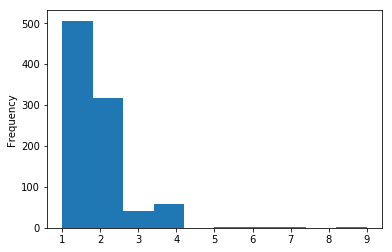

In [4]:
numberWithMoreThanOne = 0
dist = []
for protID, confirmedTracrs in confirmedResults.items():
    dist.append(len(confirmedTracrs))
    numberWithMoreThanOne += int(len(confirmedTracrs) >3)
numberWithMoreThanOne
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

In [10]:
fh = open("sequences/%_tracrRNASeqs.fasta","w")
for protID, confirmedTracrs in confirmedResults.items():
    for tracr in confirmedTracrs:
        print(tracr)
        print(dir(tracr))
        break
    break

fh.close()

Seq_2583750_2584137_D	True	[30	94] +	False	
['Rholocation', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'genomeLocation', 'name', 'strand', 'upstream']


In [ ]:
from ete3 import Tree
print("REading tree")
tree = Tree("trees/Cas9-Like-clustered.faa.tree")
nodeList = []
nodeTable = {}
for node1 in tree.traverse(): nodeList.append(node1)
print(len(nodeList))
last = nodeList[-2]

for i, node1 in enumerate(nodeList):
    if i%100 == 0:print(i, end=' ')
    for node2 in nodeList[i+1:]:
        combinedID = idMap(node1.name,node2.name,nodeTable)
        print(node1.get_common_ancestor(node2))
        nodeTable[combinedID] = node1.get_distance(node2)
        break
    if i >= 5:break
    if node1 == last:break

### Data


In [2]:
infernalResults = ProcessInfernal(1,'Cas9')
generateColors

Dumping /mnt/research/germs/shane/transActRNA/data/pickles/InfernalResults02.p Number of results: 1119


### For each system, find out how many unique structures where found by checking overlap

In [4]:
condensedResults = {} # {SeqID:[set(tracrLocations)]}
for seqID in infernalResults:
    condensedResults[seqID]=[]
    tracrCoords = set()
    for hit in infernalResults.seqTracrs[seqID].values():
        start = min(hit.location.start,hit.location.end)
        end = max(hit.location.start,hit.location.end)
        coords = set(range(start,end))
        if len(coords.intersection(tracrCoords)) == 0:
            tracrCoords = tracrCoords.union(coords)
            condensedResults[seqID].append(hit)
print len(condensedResults)    

1119


count    1119.000000
mean        2.271671
std         1.502952
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        12.000000
dtype: float64


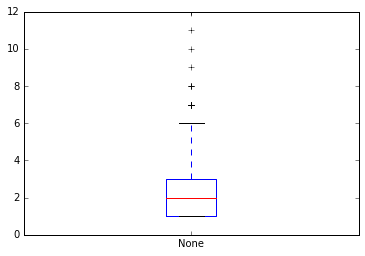

In [5]:
dist = []
for hitList in condensedResults.values(): dist.append(len(hitList))
    
dist = Series(dist)
print dist.describe()
dist.plot.box();

# Which hit is THE hit, and how many sequence cluster structures overlap it?

In [3]:
from collections import Counter
def findBiggestCluster(clusters, clusterMap): return Counter(dict((k, clusterMap[k]) for k in (clusters))).most_common(1)[0][0] 
clusterCounter = {}
for struct,ids in infernalResults.structMapping.iteritems(): clusterCounter[struct] = len(ids)

In [3]:
testCounter = 0
tracrNumDist = []
biggestClusterMap = {} # {"ClusterName:set([SeqID,...])}
SeqClusterMap = {}
combineWsomethingElse=0
for seqID in infernalResults:
    testCounter +=1
#     print "\nSeqID:",seqID
    biggestCluster =  findBiggestCluster(infernalResults[seqID],clusterCounter)
    combo = infernalResults[seqID].intersection(biggestClusterMap.keys())
    if biggestCluster in combo:combo.remove(biggestCluster)
    if biggestCluster not in biggestClusterMap and len(combo) >0:
        biggestCluster =  findBiggestCluster(combo,clusterCounter)
    try: biggestClusterMap[biggestCluster].add(seqID)
    except: biggestClusterMap[biggestCluster] = set([seqID])
    SeqClusterMap[seqID] = biggestCluster
    hitInfo = infernalResults.seqTracrs[seqID][biggestCluster]
#     print "\tMain Tracr:",hitInfo
    overlapCount = 0
    nonOverlapping = {}
    for hit in infernalResults.seqTracrs[seqID].values():
        if hit.structName == hitInfo.structName and hit.location == hitInfo.location: continue
        elif hit.location.overlaps(hitInfo.location):
            #print "\t\tOverlaps:",hit
            overlapCount +=1
        else: nonOverlapping[hit.structName]=hit
#     print "\t\tPrimary Tracr Overlap:",overlapCount
    tracrCounter = 1
    while len(nonOverlapping)> 1:
        tracrCounter+=1
        overlapCount = 0
        biggestCluster = findBiggestCluster(nonOverlapping.keys(),clusterCounter)
        hitInfo = nonOverlapping[biggestCluster]
#         print "\tAlternative tracr %i: %s" % (counter, hitInfo)
        del nonOverlapping[biggestCluster]
        removeList = []
        for hit in nonOverlapping.values(): 
            if hit.location.overlaps(hitInfo.location):
                #print "\t\tOverlaps:",hit
                overlapCount +=1
                removeList.append(hit.structName)
#         print "\t\tAlternative Tracr Overlap:",overlapCount
        for hitName in removeList: del nonOverlapping[hitName]
    if tracrCounter >=10:
        print seqID
    tracrNumDist.append(tracrCounter)
#     if testCounter == 10:break
    

NZ_CP016877.1_ORF2
NZ_CM003138.1_ORF2
NZ_CP019935.1_ORF2


In [4]:
infernalResults_1 = ProcessInfernal(0)

Empty Output File:  Cluster_58.out 0
Empty Output File:  Cluster_89.out 0
Empty Output File:  Cluster_55.out 0
Empty Output File:  Cluster_75.out 0
Empty Output File:  Cluster_125.out 0
Empty Output File:  Cluster_155.out 0
Empty Output File:  Cluster_20.out 0
Empty Output File:  Cluster_142.out 0
Dumping /mnt/research/germs/shane/transActRNA/data/pickles/InfernalResults00.p Number of results: 977


In [11]:
allLoci = pickle.load(open("pickles/TracrLoci.p","rb"))
for seqID in infernalResults:
    if seqID not in allLoci:continue
    seqLocus = allLoci[seqID]
    print seqID
    print "\tStuct Hits:"
    for hit in infernalResults.seqTracrs[seqID].values():
        print "\t\t",hit
    print "\tPossible Tracrs:"
    for coord in seqLocus.possibleTracrs:
        print "\t\t",coord
    print
    

NZ_MNPS01000005.1_ORF3
	Stuct Hits:
		Cluster_1222 [165929	166048]+ 2.5e-08
	Possible Tracrs:
		[166026	166050]+
		[170517	170553]+
		[171310	171346]+

PHEF01000089_ORF1
	Stuct Hits:
		Cluster_1084 [6236	6328]+ 3.2e-07
	Possible Tracrs:
		[6242	6268]+
		[133	169]+
		[1454	1490]+

NZ_LNKK01000004.1_ORF2
	Stuct Hits:
		Cluster_1209 [2181	2283]+ 0.0022
	Possible Tracrs:
		[0	24]+
		[2152	2176]+
		[186	222]+

NVXA01000008_ORF1
	Stuct Hits:
		Cluster_1084 [102984	103076]+ 5.1e-10
	Possible Tracrs:
		[108529	108547]+
		[103048	103069]+
		[107662	107699]+

NZ_BAMU01000030.1_ORF3
	Stuct Hits:
		Cluster_1222 [21152	21294]+ 1.3e-37
	Possible Tracrs:
		[14192	14228]+
		[16635	16671]+
		[21151	21173]+

ONBR01000009_ORF2
	Stuct Hits:
		Cluster_1054 [7853	7961]+ 5.2e-09
	Possible Tracrs:
		[7850	7874]+
		[724	760]+
		[1581	1617]+

DKSH01000019_ORF2
	Stuct Hits:
		Cluster_1054 [2192	2332]+ 6.6e-08
	Possible Tracrs:
		[0	35]+
		[8181	8203]+
		[1910	1946]+

NZ_ANBM01000003.1_ORF3
	Stuct Hits:
		Cluster

In [42]:
from random import randint

r = lambda: randint(0,255)            
def color():return '#%02X%02X%02X' % (r(),r(),r())

In [54]:
import glob
for id in infernalResults_1:
    if id not in SeqClusterMap:continue
    if SeqClusterMap[id] in biggestClusterMap: del biggestClusterMap[SeqClusterMap[id]]

counter, treeColors = {},{}
for id,seqs in biggestClusterMap.iteritems(): 
    counter[id]=len(seqs)
    clusterColor = color()
    for seqID in seqs: treeColors[seqID] = clusterColor
pickle.dump(treeColors,open("pickles/NovelTracrs.p","wb"))
print len(treeColors)
counter = Counter(counter)
for clusterID,count in counter.most_common(100): 
    if count>1:
        print clusterID, count
        chdir("conseqs2/"+clusterID)
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_RNAfold.pl %s.fasta > %s.dbn"
        #system(cmd % (clusterID,clusterID))
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_VARNA_images.pl %s.dbn"
        #system(cmd % (clusterID))
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_VARNA_images.pl %s.bt"
        system(cmd % (clusterID))
        jpgs = glob.glob("*.jpg")
        for pic in jpgs:
            system("cp %s /mnt/research/germs/shane/transActRNA/data/images/novel/%s" % (pic,clusterID+pic))
        chdir("../../")

77
Cluster_166 15
Cluster_1084 13
Cluster_706 7
Cluster_1222 6
Cluster_457 4
Cluster_1461 4
Cluster_1729 3
Cluster_1584 3
Cluster_909 3
Cluster_581 2
Cluster_1054 2
Cluster_401 2
Cluster_282 2
Cluster_1441 2
Cluster_1553 2


In [8]:
tracrNumDist = Series(tracrNumDist)

In [49]:
%%bash
pwd


/mnt/research/germs/shane/transActRNA/data/conseqs0/Cluster_166


count    1119.000000
mean        1.923146
std         1.314359
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        12.000000
dtype: float64


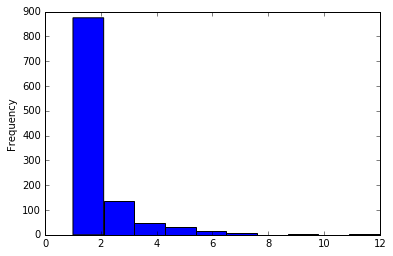

In [9]:
print tracrNumDist.describe()
tracrNumDist.plot.hist();

# Generate Images of each cluster

#### Fold the tracrRNAs and generate an image

In [ ]:
chdir("conseqs2")
newTracrPath = ""
files = os.listdir("./")
for dirname in files:
    chdir(dirname)
    os.system("perl RNACompare/HTP_RNAfold.pl %s >%s.dbn" %(kozak_path+filename,kozak_path+filename))
    os.system("perl RNACompare/HTP_VARNA_images.pl %s > cmd" % filename)
    chdir("..")

In [4]:
from optparse import OptionParser
from os import system
from Bio.SeqIO import parse

parser = OptionParser()

In [ ]:
parser.add_option(re)

# Save the session

In [10]:
dill.dump_session('pickles/Step4.db')

### For each putative tracrRNA, compare to see if there is overlap between the consensus blast results

In [5]:
condensedResults

{'NZ_NDGA01000017.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c65a8>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6638>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c66c8>],
 'NZ_GL379772.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6758>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c67e8>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6878>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6908>],
 'NZ_KE150494.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6998>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6a28>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6ab8>],
 'NZ_AZFB01000003.1_ORF2': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6b48>],
 'NZ_AZDX01000018.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6bd8>],
 'MEEU01000082_ORF3': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6cb0>],
 'NZ_ALSD01000016.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6d88>,
  <InfernalRe

### Figure out the direction of the tracrRNA 

In [ ]:
os.chdir(kozak_path)
files = os.listdir("./")
for filename in files:
    if ".dbn" not in filename:continue
    #os.system("perl RNACompare/HTP_VARNA_images.pl %s > cmd" % filename)

In [ ]:
os.chdir("../RNACompare")

In [ ]:
%%bash
pwd
#ls -alh Kozak/
#rm Kozak/*.fa Kozak/*.dbn

In [ ]:
# for rec in parse("Random_200.txt_out.txt","fasta"):
#     fh = open("kozaks/%s.fa" % (rec.id),"w")
#     fh.write(">%s\n%s\n" % (rec.id,str(rec.seq)))
#     fh.close()    

In [ ]:
files = os.listdir("kozaks/")
for filename in files:
    if ".gb" in filename:continue
    #os.system("perl RNACompare/HTP_RNAfold.pl kozaks/%s >kozaks/%s.dbn" %(filename,filename))

In [ ]:
files = os.listdir("kozaks/")
for filename in files:
    if ".dbn" not in filename:continue
    #print "perl HTP_VARNA_images.pl kozaks/%s > VARNA_cmdline.txt" % (filename)
    #os.system("perl HTP_VARNA_images.pl kozaks/%s > VARNA_cmdline.txt" % (filename))